# Analyse MD simulation of ice

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
from rigid_flows.systems.watermodel import WaterModel, plot_energy

In [4]:
temp = 250
water_type = 'tip4pice'
rigidWater = True
ice_type = 'XI'
n_waters = 16

# path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
path = f'/import/a12/users/minvernizzi/scratch-allegro/ice/tip4pice/N{n_waters}_T{50}/'
info = f'ice{ice_type}_T{temp:g}_N{n_waters}'
if water_type != 'tip4pew':
    info = f'{water_type}_{info}'
if not rigidWater:
    info = f'flex_{info}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
data = np.load(f'{path}MDtraj-{info}.npz')
pos = data['pos']
box = data['box']
ene = data['ene']

if model.is_box_orthorombic:
    toPBC = True
else:
    toPBC = False
    print('WARNING: you are working with a non-orthorombic box')

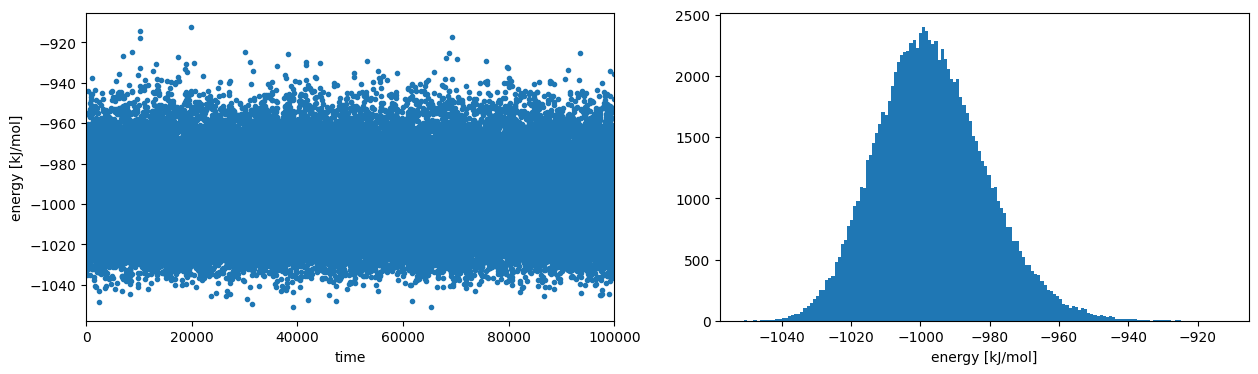

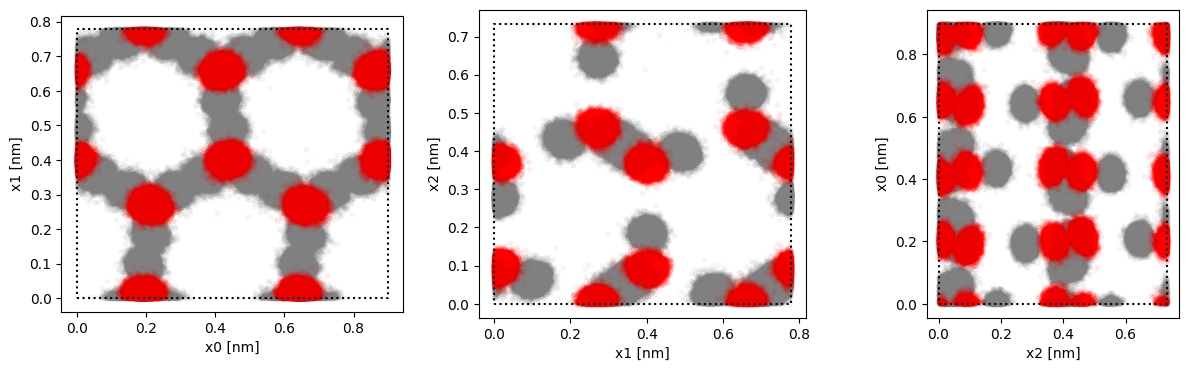

In [5]:
plot_energy(ene)
model.plot_2Dview(pos[::10], box[::10], toPBC=toPBC)

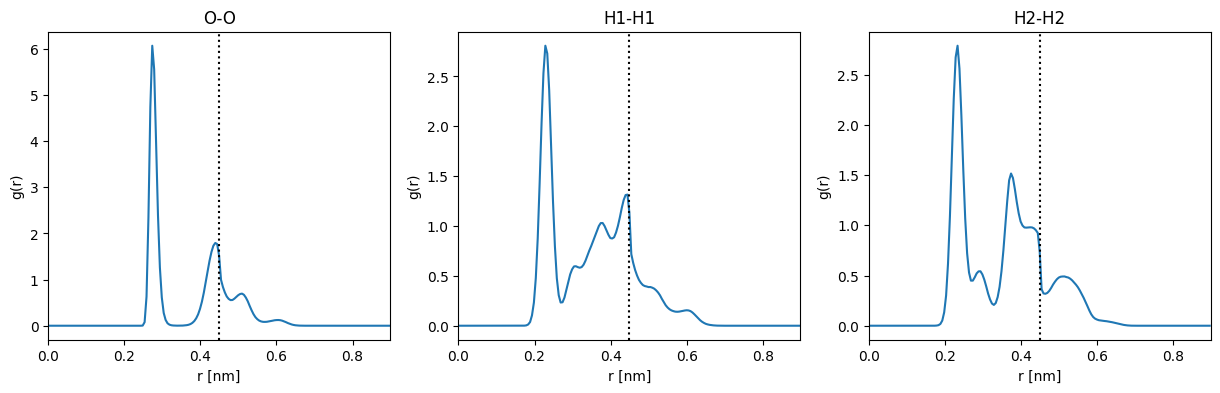

In [6]:
#plot rdf
r_range = [0, model.box.max()]

names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    plt.title(f'{a}-{a}')
    model.plot_rdf(pos, r_range=r_range, selection=f'name == {a}')
    plt.axvline(model.box.max()/2, ls=':', c='k')
    n += 1
    
plt.show()

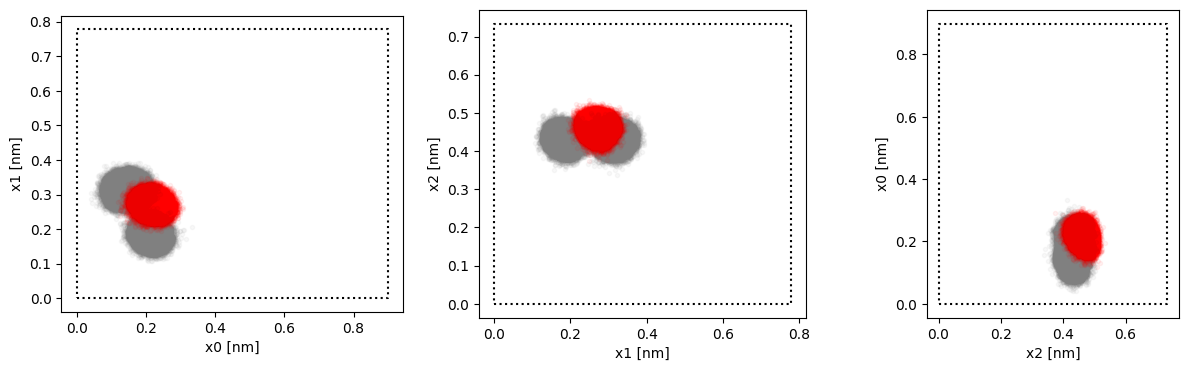

(0.019366556218802167, array([0.02235855, 0.01868776, 0.01705336]))

In [7]:
i = model.n_sites * 3
mypos = pos[:,i:i+4]
model.plot_2Dview(mypos)
mypos[:,0].std(axis=0).mean(), mypos[:,0].std(axis=0)

a deeper look into particle distances

In [8]:
tran = 10_000
mypos = pos[:tran, ::model.n_sites]
# mypos = pos[:tran]
deltas = mypos[:, :, None, :] - mypos[:, None, :, :]

In [9]:
box_lenghts = np.diag(model.box)[None,None,None,:]
box_lenghts.shape, box_lenghts

((1, 1, 1, 3), array([[[[0.89846, 0.77808, 0.73358]]]]))

In [10]:
deltas_pbc = deltas - box_lenghts * np.around(deltas / box_lenghts)
deltas_pbc.max()

0.4492299339748567

In [11]:
deltas_rescaled = deltas / box_lenghts
deltas_pbc_rescaled = deltas_pbc / box_lenghts
r = np.sqrt(np.sum(deltas**2, axis=-1))
r_pbc = np.sqrt(np.sum(deltas_pbc**2, axis=-1))

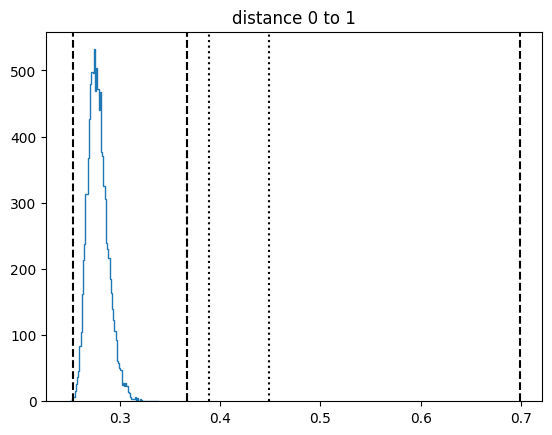

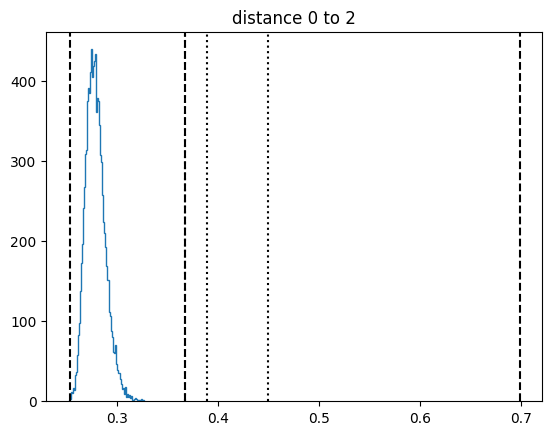

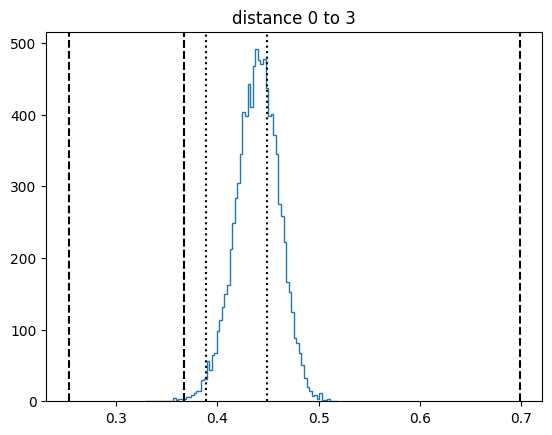

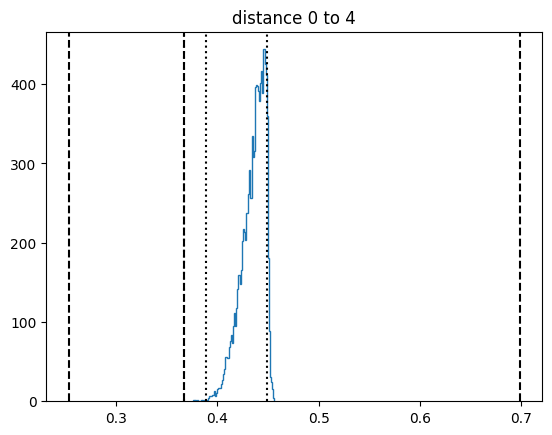

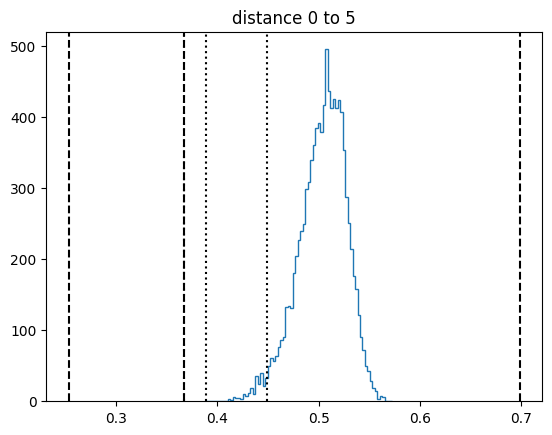

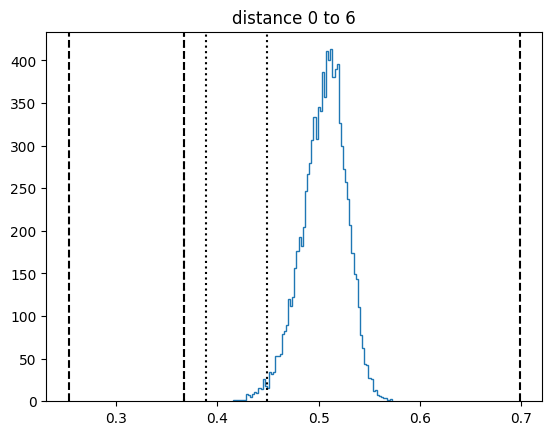

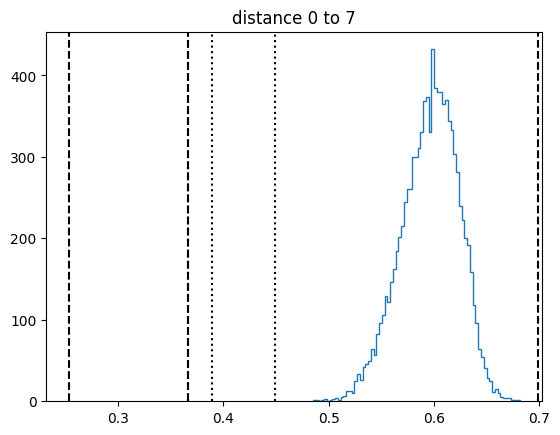

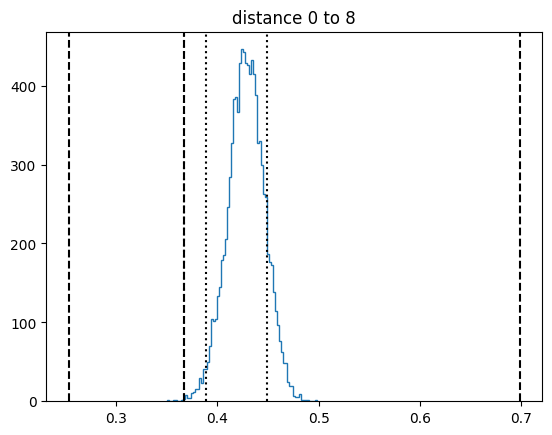

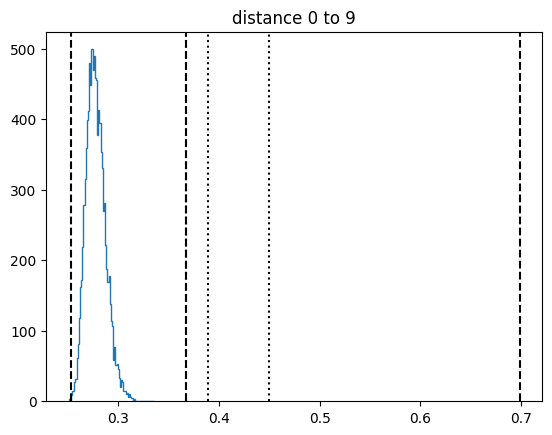

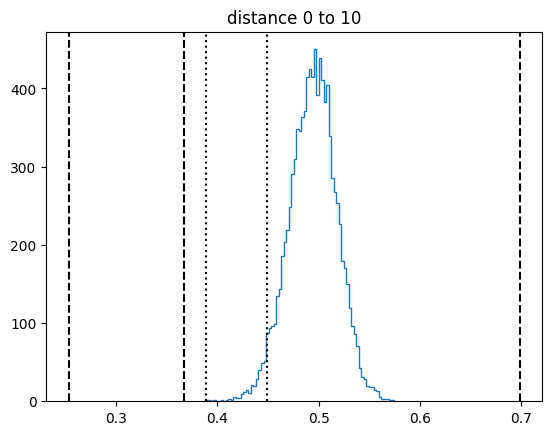

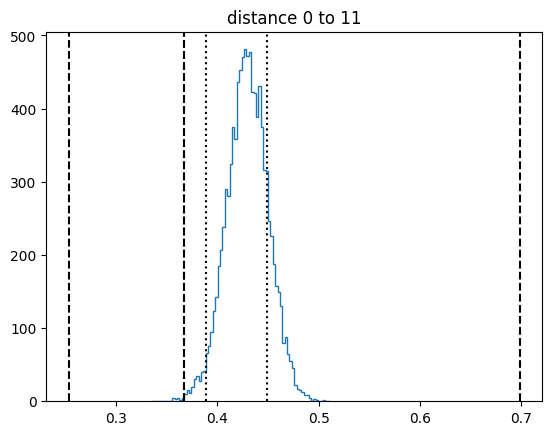

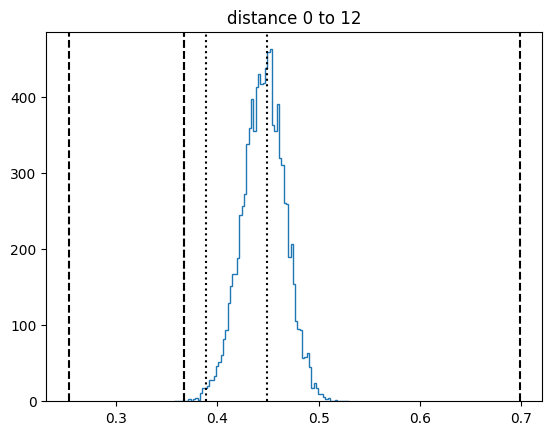

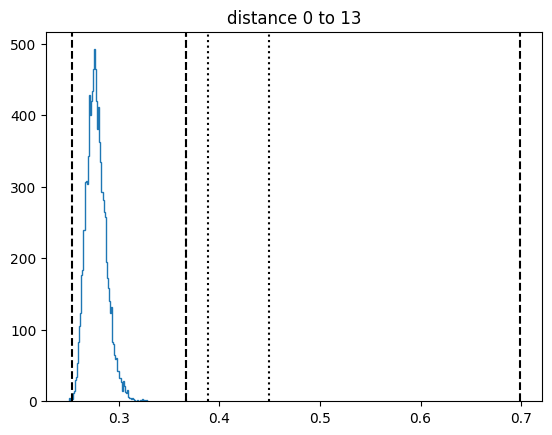

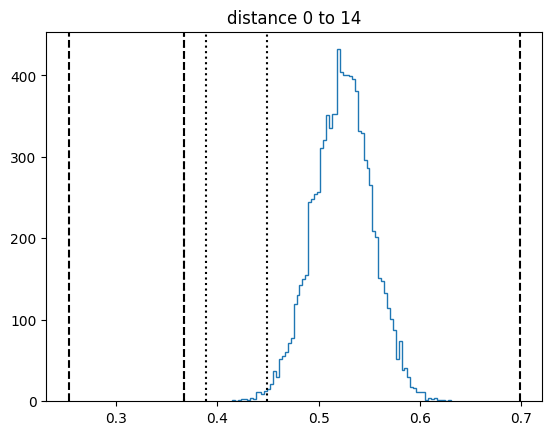

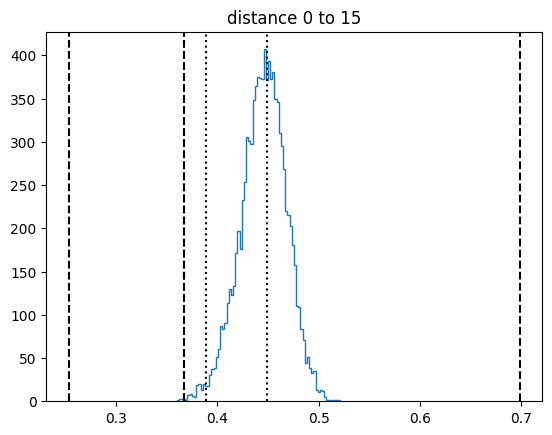

In [12]:
i = 0
for j in range(model.n_molecules):
    if i != j:
        plt.title(f'distance {i} to {j}')
        # plt.hist(deltas_pbc[:,i,j], bins=75, histtype='step')
        # plt.hist(deltas_pbc_rescaled[:,i,j], bins=75, histtype='step')
        # plt.hist(deltas[:,i,j], bins=75, histtype='step')
        plt.hist(r_pbc[:,i,j], bins=75, histtype='step')
        # plt.axvline(0, c='k', ls=':')
        # plt.axvline(0.5**(1/3), c='k', ls=':')
        plt.axvline(0.8*model.sigma_O, c='k', ls='--') #linearization below this
        plt.axvline(model.nonbondedCutoff, c='k', ls='--') #lj is zero above
        plt.axvline(np.sqrt(np.sum(box**2))/2, c='k', ls='--') #max possible PBC distance
        for k in range(3):
            plt.axvline(box[0,k,k]/2, c='k', ls=':')
        plt.show()

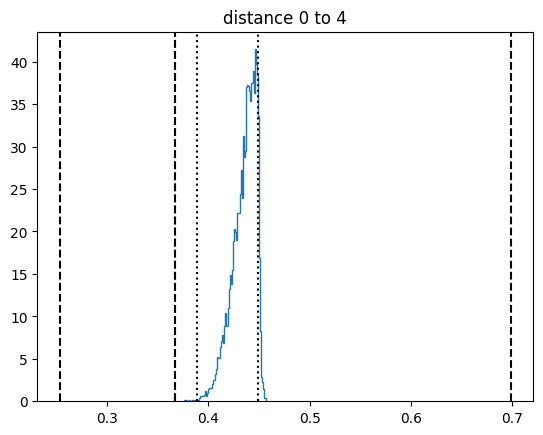

oxygen 0


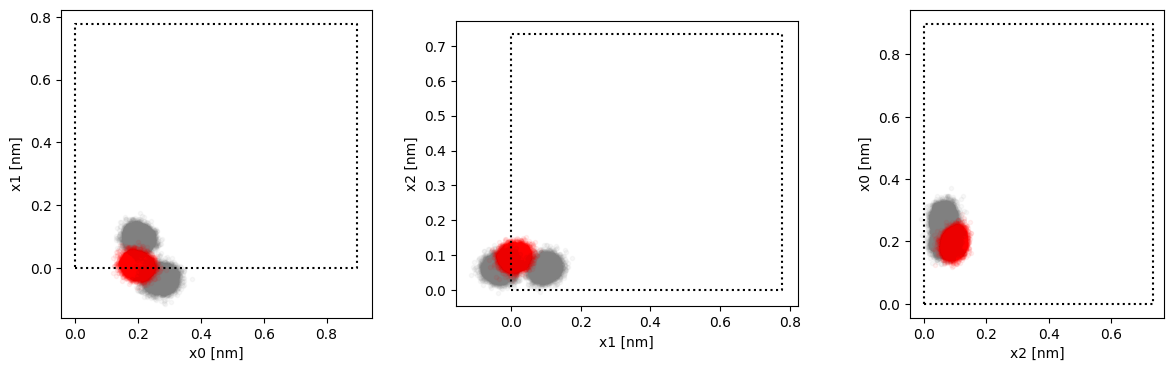

oxygen 4


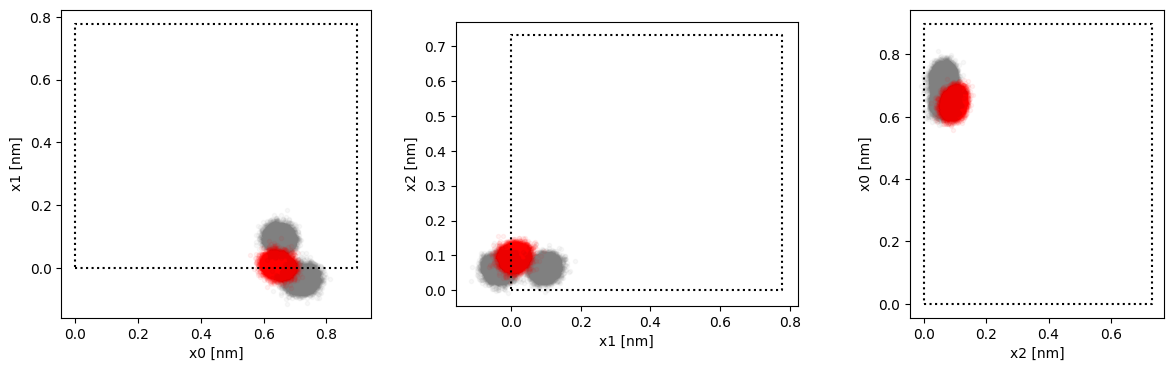

In [13]:
j = 4
plt.title(f'distance {i} to {j}')
# plt.hist(r[:,i,j], bins=75, histtype='step', density=True)
plt.hist(r_pbc[:,i,j], bins=75, histtype='step', density=True)
# plt.hist(deltas_rescaled[:,i,j], bins=75, histtype='step', density=True)
# plt.hist(deltas_pbc_rescaled[:,i,j], bins=75, histtype='step', density=True)
plt.axvline(0.8*model.sigma_O, c='k', ls='--') #linearization below this
plt.axvline(model.nonbondedCutoff, c='k', ls='--') #lj is zero above
plt.axvline(np.sqrt(np.sum(box**2))/2, c='k', ls='--') #max possible PBC distance
for k in range(3):
    plt.axvline(box[0,k,k]/2, c='k', ls=':')
plt.show()

print(f'oxygen {i}')
ox_s = model.n_sites * i
mypos_s = pos[:tran,ox_s:ox_s+4]
model.plot_2Dview(mypos_s)

print(f'oxygen {j}')
ox_s = model.n_sites * j
mypos_s = pos[:tran,ox_s:ox_s+4]
model.plot_2Dview(mypos_s)

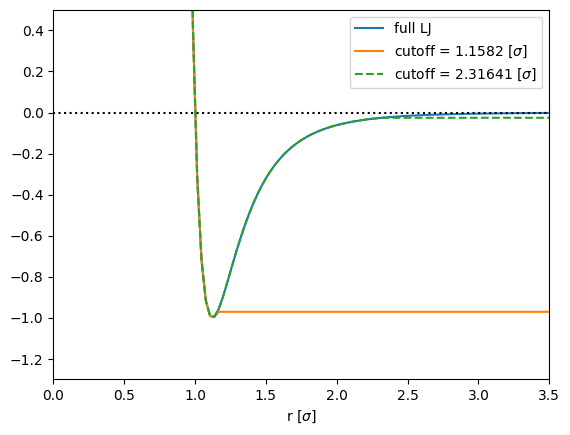

In [19]:
def LennardJones(r, cutoff=None):
    if cutoff is None:
        return 4*(r**(-12)-r**(-6))
    else:
        return np.where(r<cutoff, LennardJones(r), LennardJones(cutoff))
    
r = np.linspace(0.5, 3.5, 100)
plt.plot(r, LennardJones(r), label='full LJ')
cutoff = model.nonbondedCutoff / model.sigma_O
plt.plot(r, LennardJones(r, cutoff), label=f'cutoff = {cutoff:g} [$\sigma$]')
cutoff *= 2
plt.plot(r, LennardJones(r, cutoff), ls='--', label=f'cutoff = {cutoff:g} [$\sigma$]')

plt.axhline(0, c='k', ls=':')
plt.ylim(-1.3, .5)
plt.xlim(0, 3.5)
plt.xlabel('r [$\sigma$]')
plt.legend()
plt.show()